In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import utils
import numpy as np
import pandas as pd
import json
import tqdm
import matplotlib.pyplot as plt

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic



In [3]:
path = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0'

#### LOAD DATASETS ####
dataset             = pd.read_csv(os.path.join(path, 'Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()

# Zero-center data
for key in description:
    dataset[key]    = (dataset[key] - description[key]['mean'])/description[key]['std']

Pon = load_data(os.path.join(path, 'Pon.csv'))
Ppeak = load_data(os.path.join(path, 'Ppeak.csv'))
Poff = load_data(os.path.join(path, 'Poff.csv'))

QRSon = load_data(os.path.join(path, 'QRSon.csv'))
QRSpeak = load_data(os.path.join(path, 'QRSpeak.csv'))
QRSoff = load_data(os.path.join(path, 'QRSoff.csv'))

Ton = load_data(os.path.join(path, 'Ton.csv'))
Tpeak = load_data(os.path.join(path, 'Tpeak.csv'))
Toff = load_data(os.path.join(path, 'Toff.csv'))

In [4]:
Pwaves = {}
PQwaves = {}
QRSwaves = {}
STwaves = {}
Twaves = {}
TPwaves = {}

for k in dataset:
    for i in range(len(Pon[k])):
        Pwaves[k + '_' + str(i)] = dataset[k][Pon[k][i]:Poff[k][i]].values
        
        # PQ wave
        if QRSon[k].size != 0:
            j = np.argmax(Poff[k][i] < QRSon[k])
            if Poff[k][i] < QRSon[k][j]: # Avoid issues with argmax
                if not np.any([
                    np.any((Pon[k] > Poff[k][i]) & (Pon[k] < QRSon[k][j])),
                    np.any((Poff[k] > Poff[k][i]) & (Poff[k] < QRSon[k][j])),
                    np.any((QRSon[k] > Poff[k][i]) & (QRSon[k] < QRSon[k][j])),
                    np.any((QRSoff[k] > Poff[k][i]) & (QRSoff[k] < QRSon[k][j])),
                    np.any((Ton[k] > Poff[k][i]) & (Ton[k] < QRSon[k][j])),
                    np.any((Toff[k] > Poff[k][i]) & (Toff[k] < QRSon[k][j])),
                ]):
                    PQwaves[k + '_' + str(i)] = dataset[k][Poff[k][i]:QRSon[k][j]].values

        # TP wave
        if Toff[k].size != 0:
            j = np.argmin(Toff[k] < Pon[k][i])-1
            if j >= 0: # Avoid issues with argmin
                if not np.any([
                    np.any((Pon[k] < Pon[k][i]) & (Pon[k] > Toff[k][j])),
                    np.any((Poff[k] < Poff[k][i]) & (Poff[k] > Toff[k][j])),
                    np.any((QRSon[k] < Poff[k][i]) & (QRSon[k] > Toff[k][j])),
                    np.any((QRSoff[k] < Poff[k][i]) & (QRSoff[k] > Toff[k][j])),
                    np.any((Ton[k] < Poff[k][i]) & (Ton[k] > Toff[k][j])),
                    np.any((Toff[k] < Poff[k][i]) & (Toff[k] > Toff[k][j])),
                ]):
                    TPwaves[k + '_' + str(i)] = dataset[k][Toff[k][j]:Pon[k][i]].values

    for i in range(len(QRSon[k])):
        QRSwaves[k + '_' + str(i)] = dataset[k][QRSon[k][i]:QRSoff[k][i]].values

        # ST wave
        if Ton[k].size != 0:
            j = np.argmax(QRSoff[k][i] < Ton[k])
            if QRSoff[k][i] < Ton[k][j]: # Avoid issues with argmax
                if not np.any([
                    np.any((Pon[k] > QRSoff[k][i]) & (Pon[k] < Ton[k][j])),
                    np.any((Poff[k] > QRSoff[k][i]) & (Poff[k] < Ton[k][j])),
                    np.any((QRSon[k] > QRSoff[k][i]) & (QRSon[k] < Ton[k][j])),
                    np.any((QRSoff[k] > QRSoff[k][i]) & (QRSoff[k] < Ton[k][j])),
                    np.any((Ton[k] > QRSoff[k][i]) & (Ton[k] < Ton[k][j])),
                    np.any((Toff[k] > QRSoff[k][i]) & (Toff[k] < Ton[k][j])),
                ]):
                    STwaves[k + '_' + str(i)] = dataset[k][QRSoff[k][i]:Ton[k][j]].values

    for i in range(len(Ton[k])):
        Twaves[k + '_' + str(i)] = dataset[k][Ton[k][i]:Toff[k][i]].values
    

In [5]:
# Filter out
Pwaves = {k : Pwaves[k] for k in Pwaves if ((Pwaves[k].size > 5) & (Pwaves[k].size < 100))}
PQwaves = {k : PQwaves[k] for k in PQwaves if ((PQwaves[k].size > 5) & (PQwaves[k].size < 100))}
QRSwaves = {k : QRSwaves[k] for k in QRSwaves if ((QRSwaves[k].size > 5) & (QRSwaves[k].size < 100))}
STwaves = {k : STwaves[k] for k in STwaves if ((STwaves[k].size > 5) & (STwaves[k].size < 100))}
Twaves = {k : Twaves[k] for k in Twaves if ((Twaves[k].size > 5) & (Twaves[k].size < 100))}
TPwaves = {k : TPwaves[k] for k in TPwaves if ((TPwaves[k].size > 5) & (TPwaves[k].size < 200))}

In [6]:
print(len(Pwaves))
print(len(PQwaves))
print(len(QRSwaves))
print(len(STwaves))
print(len(Twaves))
print(len(TPwaves))

6500
6278
7272
2724
7164
5642


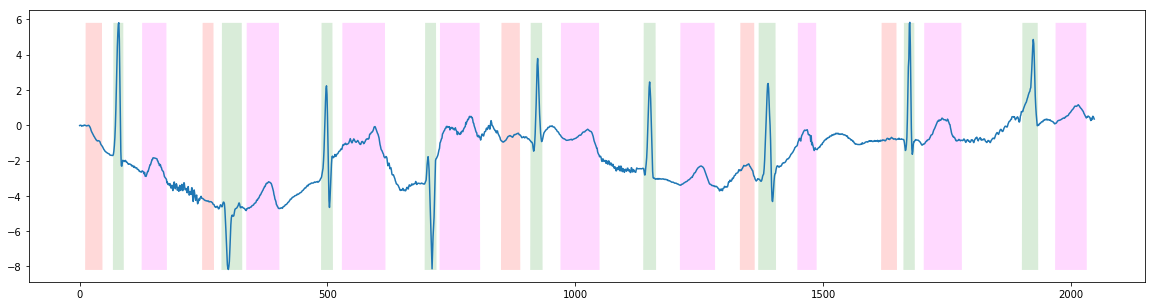

In [322]:
N = 2048

beats = []
beats.append(utils.signal.on_off_correction(TPwaves[list(TPwaves)[np.random.randint(0,len(TPwaves))]]))
size = beats[0].size
masks = np.zeros((size,))
onset = np.random.randint(0,size)
while size-onset < N:
    # P wave (sometimes)
    if np.random.rand(1) < 0.75:
        p = utils.signal.on_off_correction(Pwaves[list(Pwaves)[np.random.randint(0,len(Pwaves))]])
        beats.append(p)
        masks = np.concatenate((masks,1*np.ones((p.size,))))

    # PQ segment
    pq = utils.signal.on_off_correction(PQwaves[list(PQwaves)[np.random.randint(0,len(PQwaves))]])
    beats.append(pq)
    masks = np.concatenate((masks,np.zeros((pq.size,))))

    # QRS wave
    qrs = utils.signal.on_off_correction(QRSwaves[list(QRSwaves)[np.random.randint(0,len(QRSwaves))]])
    beats.append(qrs)
    masks = np.concatenate((masks,2*np.ones((qrs.size,))))

    # ST segment
    st = utils.signal.on_off_correction(STwaves[list(STwaves)[np.random.randint(0,len(STwaves))]])
    beats.append(st)
    masks = np.concatenate((masks,np.zeros((st.size,))))

    # T wave
    t = utils.signal.on_off_correction(Twaves[list(Twaves)[np.random.randint(0,len(Twaves))]])
    beats.append(t)
    masks = np.concatenate((masks,3*np.ones((t.size,))))

    # TP segment
    tp = utils.signal.on_off_correction(TPwaves[list(TPwaves)[np.random.randint(0,len(TPwaves))]])
    beats.append(tp)
    masks = np.concatenate((masks,np.zeros((tp.size,))))

    size = sum([beats[i].size for i in range(len(beats))])

w = 51
sig = np.concatenate(beats)[onset:onset+2048]
signal = sig + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

masks = masks[onset:onset+2048]
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = masks == 1
masks_all[:,1] = masks == 2
masks_all[:,2] = masks == 3
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

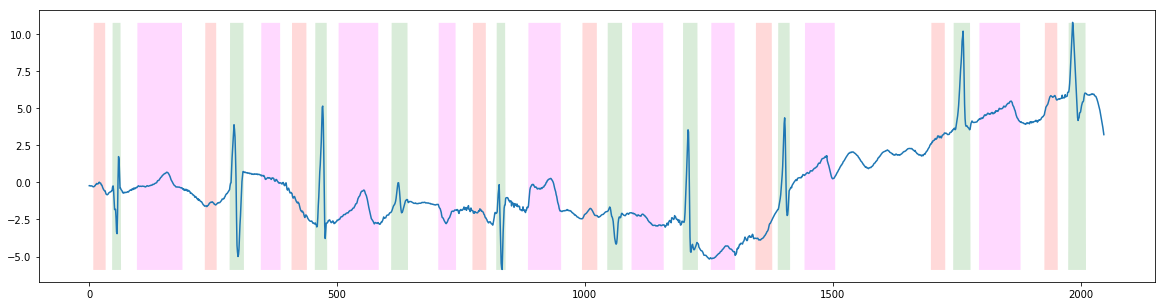

In [286]:
from scipy.stats import norm

# Number of iterations to compute.
n = 2048

# Brownian motion
w = 51
v = np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=n)),np.hamming(w)/(w/2),mode='same')

# Plot
plt.figure(figsize=(20,5))
signal = sig + v
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)
# plt.plot(sig)
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [35]:
beats[-]

array([ 0.        , -0.6199042 ,  0.46331045,  1.32910567,  2.01371804,
        2.37220127,  2.51326506,  2.54561915,  2.50550008,  2.46538102,
        2.38902539,  2.31266976,  2.23631412,  2.19619506,  2.22854914,
        2.18843008,  2.07583788,  1.99948225,  1.95936319,  1.91924412,
        1.80665192,  1.73029629,  1.65394065,  1.65005816,  1.64617567,
        1.53358347,  1.42099127,  1.34463563,  1.30451657,  1.19192437,
        1.11556874,  1.07544967,  1.03533061,  0.88650184,  0.73767306,
        0.66131743,  0.5849618 ,  0.50860616,  0.43225053,  0.39213147,
        0.35201241,  0.20318363,  0.09059143, -0.05823735, -0.17082955,
       -0.24718518, -0.32354082, -0.36365988, -0.47625208, -0.58884429,
       -0.77390963, -0.92273841, -0.99909404, -1.0392131 , -1.07933216,
       -1.1556878 , -1.23204343, -1.30839906, -1.3847547 , -1.46111033,
       -1.50122939, -1.57758502, -1.36404808, -1.29545743, -1.15439363,
       -1.08580298, -1.0534489 , -1.02109482, -0.88003102, -0.70

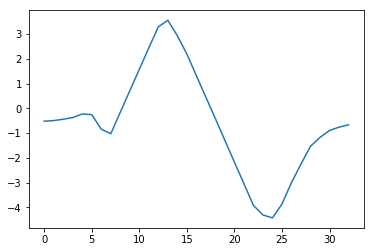

In [189]:
keys = list(QRSwaves.keys())
plt.plot(QRSwaves[keys[4789]])

In [136]:
QRSwaves[keys[300]].size

24

In [79]:
QRSwaves[keys[1967]].size

24

In [89]:
QRSwaves[keys[5293]].size

24

In [255]:
Psizes = {k : Pwaves[k].size for k in Pwaves}
PQsizes = {k : PQwaves[k].size for k in PQwaves}
QRSsizes = {k : QRSwaves[k].size for k in QRSwaves}
STsizes = {k : STwaves[k].size for k in STwaves}
Tsizes = {k : Twaves[k].size for k in Twaves}
TPsizes = {k : TPwaves[k].size for k in TPwaves}

In [272]:
for k,v in QRSsizes.items():
    if v == 407:
        swyhjykldhf

NameError: name 'swyhjykldhf' is not defined

In [283]:
np.bincount(list(TPsizes.values()))[:1000]

array([ 0,  2,  4, 16, 16, 20, 38, 36, 24, 54, 36, 44, 34, 38, 54, 20, 16,
       36, 24, 30, 28, 36, 32, 22, 22, 16, 22, 14, 30, 42, 14, 50, 26, 52,
       50, 52, 36, 42, 60, 54, 34, 36, 46, 50, 54, 34, 38, 48, 30, 46, 40,
       66, 56, 62, 56, 62, 96, 66, 72, 84, 70, 58, 66, 60, 62, 68, 86, 54,
       66, 56, 42, 52, 50, 48, 52, 52, 42, 38, 42, 44, 26, 26, 42, 32, 34,
       30, 32, 34, 18, 32, 42, 32, 36, 42, 36, 38, 38, 26, 60, 36, 28, 16,
       24, 18, 24, 24, 26, 16, 16, 24, 14, 26, 28, 32, 26, 18, 18, 18, 28,
       20, 20, 18, 36, 24, 24, 30, 24, 50, 24, 46, 28, 38, 42, 28, 44, 36,
       38, 30, 16, 34, 20, 38,  8, 30, 14, 14, 14, 10, 14,  2, 22,  8, 10,
        6,  6,  6,  6,  8,  2,  0, 14,  0,  8, 10,  4,  2,  2,  6,  2, 14,
       10,  4,  2,  8,  8,  8, 10,  8,  8, 16,  6,  6, 12, 12, 14, 14,  2,
        4,  6, 14,  2,  6,  6,  2,  4,  4,  0,  2,  2,  8,  4,  4,  4,  2,
        8,  0,  0,  0,  2,  4,  4,  4,  2,  2,  2,  2,  0,  0,  0,  2,  2,
        2,  2,  2,  2,  4

(array([2.388e+03, 2.174e+03, 9.960e+02, 2.260e+02, 9.000e+01, 4.000e+00,
        1.400e+01, 2.800e+01, 1.400e+01, 1.000e+01, 2.000e+01, 1.400e+01,
        1.800e+01, 8.000e+00, 6.000e+00, 2.200e+01, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 8.000e+00, 4.000e+00,
        4.000e+00, 0.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

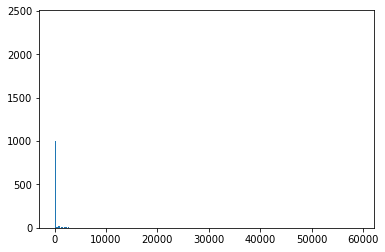

In [261]:
plt.hist(list(TPsizes.values()), bins=1000)

In [135]:
np.where(np.array(keys) == 'sel103_0_20')

(array([300]),)

In [134]:
QRSsizes

{'sel100_0_0': 18,
 'sel100_0_1': 19,
 'sel100_0_2': 17,
 'sel100_0_3': 20,
 'sel100_0_4': 19,
 'sel100_0_5': 23,
 'sel100_0_6': 21,
 'sel100_0_7': 20,
 'sel100_0_8': 22,
 'sel100_0_9': 20,
 'sel100_0_10': 19,
 'sel100_0_11': 15,
 'sel100_0_12': 18,
 'sel100_0_13': 22,
 'sel100_0_14': 20,
 'sel100_0_15': 22,
 'sel100_0_16': 20,
 'sel100_0_17': 19,
 'sel100_0_18': 22,
 'sel100_0_19': 19,
 'sel100_0_20': 19,
 'sel100_0_21': 25,
 'sel100_0_22': 19,
 'sel100_0_23': 23,
 'sel100_0_24': 19,
 'sel100_0_25': 15,
 'sel100_0_26': 17,
 'sel100_0_27': 19,
 'sel100_0_28': 19,
 'sel100_0_29': 22,
 'sel100_1_0': 18,
 'sel100_1_1': 19,
 'sel100_1_2': 17,
 'sel100_1_3': 20,
 'sel100_1_4': 19,
 'sel100_1_5': 23,
 'sel100_1_6': 21,
 'sel100_1_7': 20,
 'sel100_1_8': 22,
 'sel100_1_9': 20,
 'sel100_1_10': 19,
 'sel100_1_11': 15,
 'sel100_1_12': 18,
 'sel100_1_13': 22,
 'sel100_1_14': 20,
 'sel100_1_15': 22,
 'sel100_1_16': 20,
 'sel100_1_17': 19,
 'sel100_1_18': 22,
 'sel100_1_19': 19,
 'sel100_1_20': 19,


In [131]:
QRSwaves[keys[7144]].size

30

In [91]:
import utils.data

In [94]:
utils.data.augmentation.mixup(QRSwaves[keys[1967]],QRSwaves[keys[5293]])[0]

array([ 0.19835256,  0.16714234,  0.13462127,  0.25684045,  0.45511891,
        0.72237205,  1.07551582,  1.68489558,  2.50631771,  3.43054642,
        4.29169928,  4.96874287,  5.11902021,  4.43685829,  3.02219188,
        2.44314688,  0.28745545, -0.3856556 , -0.45569099, -0.18372483,
        0.02004715, -0.03110602, -0.13562875, -0.24736115])

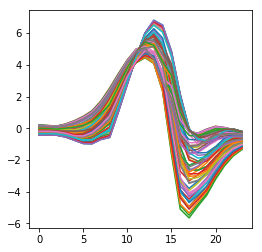

In [158]:
plt.figure(figsize=(4,4))
plt.plot(QRSwaves[keys[300]])
plt.plot(QRSwaves[keys[1967]])
plt.plot(QRSwaves[keys[5293]])
for j in range(25):
    plt.plot(utils.data.augmentation.mixup(QRSwaves[keys[300]],QRSwaves[keys[1967]])[0])
    plt.plot(utils.data.augmentation.mixup(QRSwaves[keys[300]],QRSwaves[keys[5293]])[0])
    plt.plot(utils.data.augmentation.mixup(QRSwaves[keys[1967]],QRSwaves[keys[5293]])[0])